# Creating a Sentiment Analysis Web App
## Using PyTorch and SageMaker

_Deep Learning Nanodegree Program | Deployment_

---

Now that we have a basic understanding of how SageMaker works we will try to use it to construct a complete project from end to end. Our goal will be to have a simple web page which a user can use to enter a movie review. The web page will then send the review off to our deployed model which will predict the sentiment of the entered review.

## Instructions

Some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this notebook. You will not need to modify the included code beyond what is requested. Sections that begin with '**TODO**' in the header indicate that you need to complete or implement some portion within them. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `# TODO: ...` comment. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions for you to answer which relate to the task and your implementation. Each section where you will answer a question is preceded by a '**Question:**' header. Carefully read each question and provide your answer below the '**Answer:**' header by editing the Markdown cell.

> **Note**: Code and Markdown cells can be executed using the **Shift+Enter** keyboard shortcut. In addition, a cell can be edited by typically clicking it (double-click for Markdown cells) or by pressing **Enter** while it is highlighted.

## General Outline

Recall the general outline for SageMaker projects using a notebook instance.

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

For this project, you will be following the steps in the general outline with some modifications. 

First, you will not be testing the model in its own step. You will still be testing the model, however, you will do it by deploying your model and then using the deployed model by sending the test data to it. One of the reasons for doing this is so that you can make sure that your deployed model is working correctly before moving forward.

In addition, you will deploy and use your trained model a second time. In the second iteration you will customize the way that your trained model is deployed by including some of your own code. In addition, your newly deployed model will be used in the sentiment analysis web app.

In [1]:
# Make sure that we use SageMaker 1.x
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 19.1 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=240e7d6dab8272e6100f1e02788beac242fde5da3d7a042ed9ad42690bf3171a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.29.0
    Uninstalling sagemaker-2.29.0:
      Successfully uninstalled sagemaker-2.29.0


## Step 1: Downloading the data

As in the XGBoost in SageMaker notebook, we will be using the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

In [2]:
%mkdir ../data
!wget -O ../data/aclImdb_v1.tar.gz http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxf ../data/aclImdb_v1.tar.gz -C ../data

mkdir: cannot create directory ‘../data’: File exists
--2021-03-12 04:56:06--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘../data/aclImdb_v1.tar.gz’

../data/aclImdb_v1. 100%[===================>]  80.23M  23.7MB/s    in 4.8s    

2021-03-12 04:56:11 (16.8 MB/s) - ‘../data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



## Step 2: Preparing and Processing the data

Also, as in the XGBoost notebook, we will be doing some initial data processing. The first few steps are the same as in the XGBoost example. To begin with, we will read in each of the reviews and combine them into a single input structure. Then, we will split the dataset into a training set and a testing set.

In [3]:
import os
import glob

def read_imdb_data(data_dir='../data/aclImdb'):
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    # Here we represent a positive review by '1' and a negative review by '0'
                    labels[data_type][sentiment].append(1 if sentiment == 'pos' else 0)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
                
    return data, labels

In [4]:
data, labels = read_imdb_data()
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that we've read the raw training and testing data from the downloaded dataset, we will combine the positive and negative reviews and shuffle the resulting records.

In [5]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, labels):
    """Prepare training and test sets from IMDb movie reviews."""
    
    #Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    #Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [6]:
train_X, test_X, train_y, test_y = prepare_imdb_data(data, labels)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train_X), len(test_X)))

IMDb reviews (combined): train = 25000, test = 25000


Now that we have our training and testing sets unified and prepared, we should do a quick check and see an example of the data our model will be trained on. This is generally a good idea as it allows you to see how each of the further processing steps affects the reviews and it also ensures that the data has been loaded correctly.

In [7]:
print(train_X[100])
print(train_y[100])

Lexi befriends Jennifer, a thin, intelligent girl at her new school. Lexi's parents have just split up. Soon, Jen tells Lexi of her eating disorder, and the two begin dieting and exercising together. They both are in the school's volley ball team. Lexi's mum becomes aware of her daughter's illness, as she is losing lots of weight. Lexi is admitted to hospital. She is diagnosed with Anorexia nervosa, and is made to gain weight. Her father visits her in hospital, and orders a feeding tube. She is better and is allowed out of hospital and she tells her mum that Jen has bulimia. This leads to the two falling out, as Lexi's mum tells Jen's mum her suspicions.<br /><br />At a party Jen is hit by a car, and because her heart is weak it kills her. Lexi's condition worsens, as she blames herself for her best friend's death...
1


The first step in processing the reviews is to make sure that any html tags that appear should be removed. In addition we wish to tokenize our input, that way words such as *entertained* and *entertaining* are considered the same with regard to sentiment analysis.

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

The `review_to_words` method defined above uses `BeautifulSoup` to remove any html tags that appear and uses the `nltk` package to tokenize the reviews. As a check to ensure we know how everything is working, try applying `review_to_words` to one of the reviews in the training set.

In [9]:
# TODO: Apply review_to_words to a review (train_X[100] or any other review)
print(review_to_words(train_X[50]))

['affin', 'toward', 'type', 'filmmak', 'healthi', 'appreci', 'documentari', 'honestli', 'say', 'angri', 'bother', 'sit', 'entir', 'length', '20', 'date', 'wast', 'time', 'plot', 'may', 'read', 'review', 'say', 'though', 'berkowitz', 'hyper', 'woodi', 'allen', 'style', 'narrat', 'extrem', 'annoy', 'either', 'wish', 'lay', 'coffe', 'ingest', 'tranquil', 'potenti', 'appar', 'berkowitz', 'film', 'bad', 'idea', 'part', 'detail', 'trial', 'financ', 'documentari', 'forgiv', 'disguis', 'insult', 'compliment', 'give', 'credit', 'berkowitz', 'skill', 'convinc', 'idiot', 'financ', 'horrid', 'piec', 'appreci', 'boundari', 'intent', 'film', 'even', 'regard', 'standard', 'berkowitz', 'set', 'fire', 'miss', 'level', 'close', 'sure', 'mani', 'femal', 'companion', 'eas', 'go', 'date', 'twitchi', 'wanna', 'filmmak', 'therefor', 'question', 'film', 'sens', 'authent', 'hey', 'myle', 'love', 'film', 'first', 'time', 'saw', 'appear', 'episod', 'seinfeld', 'film', 'direct', 'woodi', 'allen', 'kevin', 'smith'

**Question:** Above we mentioned that `review_to_words` method removes html formatting and allows us to tokenize the words found in a review, for example, converting *entertained* and *entertaining* into *entertain* so that they are treated as though they are the same word. What else, if anything, does this method do to the input?

**Answer:**

The method below applies the `review_to_words` method to each of the reviews in the training and testing datasets. In addition it caches the results. This is because performing this processing step can take a long time. This way if you are unable to complete the notebook in the current session, you can come back without needing to process the data a second time.

In [10]:
import pickle

cache_dir = os.path.join("../cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [11]:
# Preprocess data
train_X, test_X, train_y, test_y = preprocess_data(train_X, test_X, train_y, test_y)

Read preprocessed data from cache file: preprocessed_data.pkl


## Transform the data

In the XGBoost notebook we transformed the data from its word representation to a bag-of-words feature representation. For the model we are going to construct in this notebook we will construct a feature representation which is very similar. To start, we will represent each word as an integer. Of course, some of the words that appear in the reviews occur very infrequently and so likely don't contain much information for the purposes of sentiment analysis. The way we will deal with this problem is that we will fix the size of our working vocabulary and we will only include the words that appear most frequently. We will then combine all of the infrequent words into a single category and, in our case, we will label it as `1`.

Since we will be using a recurrent neural network, it will be convenient if the length of each review is the same. To do this, we will fix a size for our reviews and then pad short reviews with the category 'no word' (which we will label `0`) and truncate long reviews.

### (TODO) Create a word dictionary

To begin with, we need to construct a way to map words that appear in the reviews to integers. Here we fix the size of our vocabulary (including the 'no word' and 'infrequent' categories) to be `5000` but you may wish to change this to see how it affects the model.

> **TODO:** Complete the implementation for the `build_dict()` method below. Note that even though the vocab_size is set to `5000`, we only want to construct a mapping for the most frequently appearing `4998` words. This is because we want to reserve the special labels `0` for 'no word' and `1` for 'infrequent word'.

In [12]:
print(len(train_X))
print(train_X[1])

25000
['movi', 'badli', 'written', 'direct', 'act', 'beggar', 'belief', 'remad', 'better', 'script', 'director', 'cast', 'servic', 'worst', 'problem', 'act', 'jennif', 'beal', 'one', 'hand', 'polish', 'profession', 'total', 'believ', 'hand', 'ri', 'chard', 'woefulli', 'miscast', 'jar', 'particular', 'piec', 'peter', 'gallagh', 'jenni', 'levin', 'aw', 'slave', 'own', 'keep', 'coupl', 'although', 'normal', 'fine', 'work', 'actor', 'director', 'attempt', 'accent', 'inconsist', 'unbeliev', 'much', 'better', 'concentr', 'good', 'job', 'actual', 'english', 'cast', 'ludicr', 'children', 'african', 'merchant', 'thu', 'less', 'social', 'desir', 'gen', 'de', 'couleur', 'societi', 'cast', 'pale', 'skin', 'actor', 'supposedli', 'social', 'desir', 'marcel', 'pronounc', 'african', 'featur', 'includ', 'obvious', 'dy', 'blond', 'fro', 'cast', 'director', 'cannot', 'bother', 'read', 'script', 'cast', 'chose', 'appropri', 'actor', 'larg', 'pool', 'extrem', 'talent', 'physic', 'divers', 'actor', 'color',

In [13]:
import numpy as np
from collections import Counter

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
        
    # Since data is a 2 dimensional list, numpy is used to flatten it
    data = list(np.concatenate(data).flat)
    
    # TODO: Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    #       sentence is a list of words.
    cnt = Counter(data)

    # A dict storing the words that appear in the reviews along with how often they occur
    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
        
    sorted_words = cnt.most_common(vocab_size)
    print('Vocabulary length:{}'.format(len(sorted_words)))
    # convert to numpy in order to remove frequency from the list of tuple returned 
    # by .most_common method, and flat the array 
    sorted_words = np.array(sorted_words)
    sorted_words = np.delete(sorted_words,1, 1).reshape(-1) 
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels

    return word_dict
    

In [14]:
word_dict = build_dict(train_X)

Vocabulary length:5000


**Question:** What are the five most frequently appearing (tokenized) words in the training set? Does it makes sense that these words appear frequently in the training set?

**Answer:**

The top 5 frequently words make completely sense, they are related to movie topics when writting reviews or opinions about a film. However, 'one' and 'like' could be words used for a person when expressing an idea.

In [15]:
# TODO: Use this space to determine the five most frequently appearing words in the training set.
# k represents the number of elements to index in the dictionary 
k = 5
out = list(word_dict.items())[0:k]
        
# printing result   
print("Dictionary Most Frequency Words :\n" + str(out))  

Dictionary Most Frequency Words :
[('movi', 2), ('film', 3), ('one', 4), ('like', 5), ('time', 6)]


### Save `word_dict`

Later on when we construct an endpoint which processes a submitted review we will need to make use of the `word_dict` which we have created. As such, we will save it to a file now for future use.

In [16]:
data_dir = '../data/pytorch' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

In [17]:
with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

### Transform the reviews

Now that we have our word dictionary which allows us to transform the words appearing in the reviews into integers, it is time to make use of it and convert our reviews to their integer sequence representation, making sure to pad or truncate to a fixed length, which in our case is `500`.

In [18]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [19]:
train_X, train_X_len = convert_and_pad_data(word_dict, train_X)
test_X, test_X_len = convert_and_pad_data(word_dict, test_X)

As a quick check to make sure that things are working as intended, check to see what one of the reviews in the training set looks like after having been processeed. Does this look reasonable? What is the length of a review in the training set?

In [20]:
# Use this cell to examine one of the processed reviews to make sure everything is working as intended.
print('Review Size:{}'.format(len(train_X[0])))
print('Number of words per Review: {}'.format(train_X_len))
print('Review Encoded:\n{}'.format(train_X[0]))

Review Size:500
Number of words per Review: [ 75 136 114 ... 125 139 129]
Review Encoded:
[ 237  393  237  393    1    1   69   35    2 4674    1  112   65  331
 1338 2013   19    5  150  625  297   19  274 3606   14    7   31   84
   22   29    2   22   29    2  277    1  150   16 1083   17  152 1267
  295  276  342  410   59    8   26    2  295  276   24    2  295  276
  112    8   24  878  326 2236    1  331    1    3 2013 1338  138  138
  937  332  439 3237    4    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   

<function matplotlib.pyplot.show(close=None, block=None)>

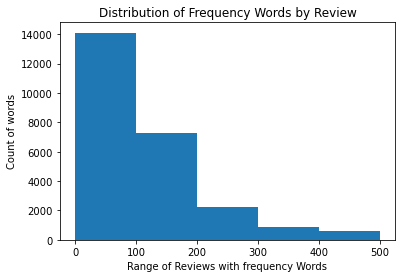

In [21]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.hist(train_X_len, bins=[0,100,200,300,400,500])
ax.set_title('Distribution of Frequency Words by Review')
ax.set_xticks([0,100,200,300,400,500])
ax.set_xlabel('Range of Reviews with frequency Words')
ax.set_ylabel('Count of words')
plt.show

**Question:** In the cells above we use the `preprocess_data` and `convert_and_pad_data` methods to process both the training and testing set. Why or why not might this be a problem?

**Answer:**

We need to process training and testing data set since our model will require the frequency words encoded. For such reason, we are using a codification for each frequency word we built in our dictionary. Also, the application of a Pad allows standarize the size of the review in terms of number of words. However, my concern is that there are 2 categories 0: 'No Word' and 1:'Infrequent' which can affect the model to learn from data. In other words, if we take a look of the above histogram, we realize that most of the reviews (around 23,500 out of 25,000 reviews ) contain less than 300 frequents words which produces a huge amount of 0: 'No word' class to fit the pad of 500 words and as a consequence it could be a problem for the model to generalize.  

## Step 3: Upload the data to S3

As in the XGBoost notebook, we will need to upload the training dataset to S3 in order for our training code to access it. For now we will save it locally and we will upload to S3 later on.

### Save the processed training dataset locally

It is important to note the format of the data that we are saving as we will need to know it when we write the training code. In our case, each row of the dataset has the form `label`, `length`, `review[500]` where `review[500]` is a sequence of `500` integers representing the words in the review.

In [22]:
import pandas as pd
    
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_len), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Uploading the training data


Next, we need to upload the training data to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [23]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sentiment_rnn'

role = sagemaker.get_execution_role()

In [24]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

**NOTE:** The cell above uploads the entire contents of our data directory. This includes the `word_dict.pkl` file. This is fortunate as we will need this later on when we create an endpoint that accepts an arbitrary review. For now, we will just take note of the fact that it resides in the data directory (and so also in the S3 training bucket) and that we will need to make sure it gets saved in the model directory.

## Step 4: Build and Train the PyTorch Model

In the XGBoost notebook we discussed what a model is in the SageMaker framework. In particular, a model comprises three objects

 - Model Artifacts,
 - Training Code, and
 - Inference Code,
 
each of which interact with one another. In the XGBoost example we used training and inference code that was provided by Amazon. Here we will still be using containers provided by Amazon with the added benefit of being able to include our own custom code.

We will start by implementing our own neural network in PyTorch along with a training script. For the purposes of this project we have provided the necessary model object in the `model.py` file, inside of the `train` folder. You can see the provided implementation by running the cell below.

In [25]:
!pygmentize train/model.py

import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=1)
        self.sig = nn.Sigmoid()
        
        self.word_dict = None

    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = x.t()
        lengths = x[0,:]
        reviews = x[1:,:]
        embeds = self.embedding(reviews)
        lstm_out, _ = self.lstm(embeds)
        out = self.dense(lstm_out)
        out = out[lengths - 1, range(len(lengths))]
        return self.sig

The important takeaway from the implementation provided is that there are three parameters that we may wish to tweak to improve the performance of our model. These are the embedding dimension, the hidden dimension and the size of the vocabulary. We will likely want to make these parameters configurable in the training script so that if we wish to modify them we do not need to modify the script itself. We will see how to do this later on. To start we will write some of the training code in the notebook so that we can more easily diagnose any issues that arise.

First we will load a small portion of the training data set to use as a sample. It would be very time consuming to try and train the model completely in the notebook as we do not have access to a gpu and the compute instance that we are using is not particularly powerful. However, we can work on a small bit of the data to get a feel for how our training script is behaving.

In [26]:
import torch
import torch.utils.data

# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=250)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

In [27]:
print(type(train_sample_dl))

<class 'torch.utils.data.dataloader.DataLoader'>


### (TODO) Writing the training method

Next we need to write the training code itself. This should be very similar to training methods that you have written before to train PyTorch models. We will leave any difficult aspects such as model saving / loading and parameter loading until a little later.

In [28]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # TODO: Complete this train method to train the model provided.
            optimizer.zero_grad()
            output = model.forward(batch_X)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()            
            
            total_loss += loss.data.item()
        print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))

Supposing we have the training method above, we will test that it is working by writing a bit of code in the notebook that executes our training method on the small sample training set that we loaded earlier. The reason for doing this in the notebook is so that we have an opportunity to fix any errors that arise early when they are easier to diagnose.

In [29]:
import torch.optim as optim
from train.model import LSTMClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

train(model, train_sample_dl, 5, optimizer, loss_fn, device)

Epoch: 1, BCELoss: 0.6905834197998046
Epoch: 2, BCELoss: 0.6821291446685791
Epoch: 3, BCELoss: 0.6747526288032532
Epoch: 4, BCELoss: 0.6661268949508667
Epoch: 5, BCELoss: 0.6548509240150452


In order to construct a PyTorch model using SageMaker we must provide SageMaker with a training script. We may optionally include a directory which will be copied to the container and from which our training code will be run. When the training container is executed it will check the uploaded directory (if there is one) for a `requirements.txt` file and install any required Python libraries, after which the training script will be run.

### (TODO) Training the model

When a PyTorch model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained. Inside of the `train` directory is a file called `train.py` which has been provided and which contains most of the necessary code to train our model. The only thing that is missing is the implementation of the `train()` method which you wrote earlier in this notebook.

**TODO**: Copy the `train()` method written above and paste it into the `train/train.py` file where required.

The way that SageMaker passes hyperparameters to the training script is by way of arguments. These arguments can then be parsed and used in the training script. To see how this is done take a look at the provided `train/train.py` file.

In [30]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 10,
                        'hidden_dim': 200,
                    })

In [31]:
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-03-12 04:57:42 Starting - Starting the training job...
2021-03-12 04:57:45 Starting - Launching requested ML instances.........
2021-03-12 04:59:14 Starting - Preparing the instances for training......
2021-03-12 05:00:24 Downloading - Downloading input data...
2021-03-12 05:01:01 Training - Downloading the training image...
2021-03-12 05:01:30 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-03-12 05:01:31,725 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-03-12 05:01:31,751 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-03-12 05:01:32,366 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-03-12 05:01:32,635 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2021-03-12 05:01:32,635 sagem

Model loaded with embedding_dim 32, hidden_dim 200, vocab_size 5000.
Epoch: 1, BCELoss: 0.6669640869510417
Epoch: 2, BCELoss: 0.5819500307647549
Epoch: 3, BCELoss: 0.4931933484515365
Epoch: 4, BCELoss: 0.4213940476884647
Epoch: 5, BCELoss: 0.3761123272837425
Epoch: 6, BCELoss: 0.3405166469058212
Epoch: 7, BCELoss: 0.3128224063892754
Epoch: 8, BCELoss: 0.2948141669740482
Epoch: 9, BCELoss: 0.28042022214860335
Epoch: 10, BCELoss: 0.2619057318993977
2021-03-12 05:04:55,025 sagemaker-containers INFO     Reporting training SUCCESS

2021-03-12 05:05:02 Uploading - Uploading generated training model
2021-03-12 05:05:02 Completed - Training job completed
Training seconds: 278
Billable seconds: 278


## Step 5: Testing the model

As mentioned at the top of this notebook, we will be testing this model by first deploying it and then sending the testing data to the deployed endpoint. We will do this so that we can make sure that the deployed model is working correctly.

## Step 6: Deploy the model for testing

Now that we have trained our model, we would like to test it to see how it performs. Currently our model takes input of the form `review_length, review[500]` where `review[500]` is a sequence of `500` integers which describe the words present in the review, encoded using `word_dict`. Fortunately for us, SageMaker provides built-in inference code for models with simple inputs such as this.

There is one thing that we need to provide, however, and that is a function which loads the saved model. This function must be called `model_fn()` and takes as its only parameter a path to the directory where the model artifacts are stored. This function must also be present in the python file which we specified as the entry point. In our case the model loading function has been provided and so no changes need to be made.

**NOTE**: When the built-in inference code is run it must import the `model_fn()` method from the `train.py` file. This is why the training code is wrapped in a main guard ( ie, `if __name__ == '__main__':` )

Since we don't need to change anything in the code that was uploaded during training, we can simply deploy the current model as-is.

**NOTE:** When deploying a model you are asking SageMaker to launch an compute instance that will wait for data to be sent to it. As a result, this compute instance will continue to run until *you* shut it down. This is important to know since the cost of a deployed endpoint depends on how long it has been running for.

In other words **If you are no longer using a deployed endpoint, shut it down!**

**TODO:** Deploy the trained model.

In [32]:
# TODO: Deploy the trained model
# Deploy my estimator to a SageMaker Endpoint and get a Predictor
predictor = estimator.deploy(instance_type='ml.m4.xlarge', initial_instance_count=1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------------!

## Step 7 - Use the model for testing

Once deployed, we can read in the test data and send it off to our deployed model to get some results. Once we collect all of the results we can determine how accurate our model is.

In [33]:
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

In [34]:
# We split the data into chunks and send each chunk seperately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [35]:
predictions = predict(test_X.values)
predictions = [round(num) for num in predictions]

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.84272

**Question:** How does this model compare to the XGBoost model you created earlier? Why might these two models perform differently on this dataset? Which do *you* think is better for sentiment analysis?

**Answer:**

XGBoost Accuracy Score: 0.86116

Recurrent NN: 0.8427

Both scores are similar, but XGBoost algorithm performed a litte bit higher. Personally, I believe LSTM is more suitable for this problem since it is design to try with sequential data and this case is not an exemption. The words are encoded sequentially in the dictionary and in my prospection LSTM can take more advantage of that than XGBoost. I think that LSTM could perform better if more tunning is made. On the other hand, I recommend to play with a pad=300 since the reviews look to be short and the padding method is aggregating many 'no word" class to the data which might be affecting the model negatively.

### (TODO) More testing

We now have a trained model which has been deployed and which we can send processed reviews to and which returns the predicted sentiment. However, ultimately we would like to be able to send our model an unprocessed review. That is, we would like to send the review itself as a string. For example, suppose we wish to send the following review to our model.

In [37]:
test_review = 'The simplest pleasures in life are the best, and this film is one of them. Combining a rather basic storyline of love and adventure this movie transcends the usual weekend fair with wit and unmitigated charm.'

The question we now need to answer is, how do we send this review to our model?

Recall in the first section of this notebook we did a bunch of data processing to the IMDb dataset. In particular, we did two specific things to the provided reviews.
 - Removed any html tags and stemmed the input
 - Encoded the review as a sequence of integers using `word_dict`
 
In order process the review we will need to repeat these two steps.

**TODO**: Using the `review_to_words` and `convert_and_pad` methods from section one, convert `test_review` into a numpy array `test_data` suitable to send to our model. Remember that our model expects input of the form `review_length, review[500]`.

In [38]:
# TODO: Convert test_review into a form usable by the model and save the results in test_data
# Apply 2 function, first to convert review in meanful words and second to encoded every word according to
# Vocabulary built previously using training dataset

test_data = review_to_words(test_review)
test_data, test_data_len = convert_and_pad(word_dict, test_data, pad=500)
test_data_input = np.array([np.array([test_data_len] + test_data)])

Now that we have processed the review, we can send the resulting array to our model to predict the sentiment of the review.

In [39]:
predictor.predict(test_data_input)

array(0.6871463, dtype=float32)

Since the return value of our model is close to `1`, we can be certain that the review we submitted is positive.

### Delete the endpoint

Of course, just like in the XGBoost notebook, once we've deployed an endpoint it continues to run until we tell it to shut down. Since we are done using our endpoint for now, we can delete it.

In [40]:
estimator.delete_endpoint()

estimator.delete_endpoint() will be deprecated in SageMaker Python SDK v2. Please use the delete_endpoint() function on your predictor instead.


## Step 6 (again) - Deploy the model for the web app

Now that we know that our model is working, it's time to create some custom inference code so that we can send the model a review which has not been processed and have it determine the sentiment of the review.

As we saw above, by default the estimator which we created, when deployed, will use the entry script and directory which we provided when creating the model. However, since we now wish to accept a string as input and our model expects a processed review, we need to write some custom inference code.

We will store the code that we write in the `serve` directory. Provided in this directory is the `model.py` file that we used to construct our model, a `utils.py` file which contains the `review_to_words` and `convert_and_pad` pre-processing functions which we used during the initial data processing, and `predict.py`, the file which will contain our custom inference code. Note also that `requirements.txt` is present which will tell SageMaker what Python libraries are required by our custom inference code.

When deploying a PyTorch model in SageMaker, you are expected to provide four functions which the SageMaker inference container will use.
 - `model_fn`: This function is the same function that we used in the training script and it tells SageMaker how to load our model.
 - `input_fn`: This function receives the raw serialized input that has been sent to the model's endpoint and its job is to de-serialize and make the input available for the inference code.
 - `output_fn`: This function takes the output of the inference code and its job is to serialize this output and return it to the caller of the model's endpoint.
 - `predict_fn`: The heart of the inference script, this is where the actual prediction is done and is the function which you will need to complete.

For the simple website that we are constructing during this project, the `input_fn` and `output_fn` methods are relatively straightforward. We only require being able to accept a string as input and we expect to return a single value as output. You might imagine though that in a more complex application the input or output may be image data or some other binary data which would require some effort to serialize.

### (TODO) Writing inference code

Before writing our custom inference code, we will begin by taking a look at the code which has been provided.

In [41]:
!pygmentize serve/predict.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from model import LSTMClassifier

from utils import review_to_words, convert_and_pad

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(model_info['embedding_dim'], model_info['hidden_dim'], model_info['vocab_size'])

    # Load the store model parameters.
    model_path = os.path.join(mod

As mentioned earlier, the `model_fn` method is the same as the one provided in the training code and the `input_fn` and `output_fn` methods are very simple and your task will be to complete the `predict_fn` method. Make sure that you save the completed file as `predict.py` in the `serve` directory.

**TODO**: Complete the `predict_fn()` method in the `serve/predict.py` file.

### Deploying the model

Now that the custom inference code has been written, we will create and deploy our model. To begin with, we need to construct a new PyTorchModel object which points to the model artifacts created during training and also points to the inference code that we wish to use. Then we can call the deploy method to launch the deployment container.

**NOTE**: The default behaviour for a deployed PyTorch model is to assume that any input passed to the predictor is a `numpy` array. In our case we want to send a string so we need to construct a simple wrapper around the `RealTimePredictor` class to accomodate simple strings. In a more complicated situation you may want to provide a serialization object, for example if you wanted to sent image data.

In [43]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------------!

### Testing the model

Now that we have deployed our model with the custom inference code, we should test to see if everything is working. Here we test our model by loading the first `250` positive and negative reviews and send them to the endpoint, then collect the results. The reason for only sending some of the data is that the amount of time it takes for our model to process the input and then perform inference is quite long and so testing the entire data set would be prohibitive.

In [44]:
import glob

def test_reviews(data_dir='../data/aclImdb', stop=250):
    
    results = []
    ground = []
    
    # We make sure to test both positive and negative reviews    
    for sentiment in ['pos', 'neg']:
        
        path = os.path.join(data_dir, 'test', sentiment, '*.txt')
        files = glob.glob(path)
        print(path + '\n')
        files_read = 0
        
        print('Starting ', sentiment, ' files')
        
        # Iterate through the files and send them to the predictor
        for f in files:
            with open(f) as review:
                # First, we store the ground truth (was the review positive or negative)
                if sentiment == 'pos':
                    ground.append(1)
                else:
                    ground.append(0)
                # Read in the review and convert to 'utf-8' for transmission via HTTP
                review_input = review.read().encode('utf-8')
                print(review_input)
                # Send the review to the predictor and store the results
                prediction = predictor.predict(review_input)
                print(prediction)
                results.append(float(prediction))
                
            # Sending reviews to our endpoint one at a time takes a while so we
            # only send a small number of reviews
            files_read += 1
            if files_read == stop:
                break
            
    return ground, results

In [45]:
ground, results = test_reviews()

../data/aclImdb/test/pos/*.txt

Starting  pos  files
b'Thomas Mann\'s controversial novel is the basis for the film "A Death in Venice. " Although in the book, the hero is an author, in the film the director Luchino Visconti who also wrote the screenplay, transforms him into a Composer. As such, the Author/Composer, Gustav Von Aschebach (Dirk Bogarde) on the verge of mental exhaustion is a burned-out artisan. After a long and successful career now seeks the peace and tranquility of a less hectic life. He decides to go on vacation to Venice where he hopes to rejuvenate his dwindling ambition. However, while staying at the picturesque seaside resort, he captures the attention of a beautiful young teenage boy, Tadzio (Bj\xc3\xb6rn Andr\xc3\xa9sen) who eyes him with curious interest and is immediately smitten by him. Although Gustav is captivated by the wondrous youth, he nevertheless must find some private time away from the boy\'s governess (Nora Ricci), while having to cope with a invad

b'1.0'
b'Vadim changed Brigitte\'s image and way of life from that of the young society beauty he had married to that of a rebellious and challenging teenager of the 1950s\xc2\x85 <br /><br />"Une Parisienne" succeeded in launching her ravishing figure as the teenage goddess, the casual sexuality, the provocative gaiety in confrontation with men\xc2\x85 <br /><br />Charles Boyer \xc2\x97 as Prince Charles \xc2\x97 was the perfect, ideal choice of those magically romantic moments\xc2\x85 His deep and vibrant voice spoke a promise of new adventures in love\xc2\x85 His deep, wondering eyes bespoke a worldly knowledge untarnished by cynicism\xc2\x85 He had the boudoir grace of Valentino without the hysteria or the sometime effeminacy of the great lover\xc2\x85 Under Michel Boisrond\'s direction, Boyer was an old-style romantic without the grand manner\xc2\x85'
b'1.0'
b'Bobby and Mikey are two little boys who move across the country with their divorced mother to start a new life. Soon after

b'1.0'
b"Okay, so this series kind of takes the route of 'here we go again!' Week in, week out David Morse's character helps out his ride who is in a bit of a pickle - but what's wrong with that!? David Morse is one of the greatest character actors out there, and certainly the coolest, and to have him in a series created by David Koepp - a great writer - is heaven!!<br /><br />Due to the lack of love for this show by many, I can't see it going to a season series - but you never know? The amount of rubbish that has made it beyond that baffles me - let's hope something good can make it past a first series!!!"
b'1.0'
b'Went looking for this movie after i read Tom Clancy\'s "Red Storm Rising" novel. Timeless masterpiece about 13th century Russians being invaded by the Germans. Movie was made in 1938, under orders from Joseph Stalin to warn Soviets about Hitler and Germany. Battle scenes are wonderfully done, showing that you don\'t need computer animation to make a great fight scene. Proba

b'1.0'
b'I, being a fan of Rupert Grint, rented this film a few months ago. I thought it was a very well written movie with a bunch of great actors. It was entertaining, and showed that Rupert Grint could play more than his most well known character of Ron Weasley. His subtle portrayal of Ben and everyone else\'s great acting made this film very likable.<br /><br />Ben, a very shy boy with a extremely religious and sensitive mother, is looking for a job. He finds one and becomes the, I guess you could call "assistant" to Evie, a retired actress. At first, it is just a way for him to earn some money. But after a while, he and Evie seem to develop a friendship. Evie helps Ben break out of his shell a little and gets him to have fun and be happy with himself, and in the end they both seem to need each other.<br /><br />Whether you are a fan of Rupert Grint or not, this movie is a really entertaining one with some very cute and moments. I highly recommend it to anybody who wants to see a g

b'1.0'
b'"Nuovomondo" was a great experience. Many filmmakers tell their stories to a big extent via dialogue. Emanuele Crialese directs his film very visually driven. For everything he wants to tell, he finds powerful images that are able to stand for themselves. Thus, he understands film as a medium that primarily tells its stories over the pictures on screen. Particularly European cinema is often very dialogue-driven (and many of the young US-American directors are strongly influenced by that). Crialese\'s opposite attitude was really the point, that made this film special for me. It has also a very interesting topic that is wrapped up in a quite unusual story and told with humour. Vincenzo Amato is outstanding as family head Salvatore, as well as the amazing Charlotte Gainsbourg, who I enjoy watching in every single one of her movies. There are many great sequences in this movie. Just to pick one: When the ship leaves Italy and the people just quietly stare. This scene is great, pa

b'1.0'
b'Truly unique and stunning film of Jules Verne\'s "For The Flag" by the Czech master director Karel Zeman.Although the story is enacted in a rather understated late Victorian style, the visuals are a knockout. Zeman uses animation, graphics, painted sets, model animation combined with live action to create the atmosphere of Verne that the reader associates in his mind. The style resembles the steel engravings of Dore and Bennet and Riou that illustrated these stories with a healthy dose of Georges Melies added.Photographed in beautiful black and white the animation is of the highest order and not of a Saturday morning variety. There are underwater sequences where the fishes swimming about are so accurately drawn they can be used in a field guide.There are images of ships ,submarines, flying craft, castles,and machinery that are drawn in such accurate detail that one must have a freeze frame on his VCR or DVD to pause the scene and study the remarkable detail that went into this

b'1.0'
b'This is a cherished movie from my childhood!! I can still hum the theme song at the drop of a hat!! I remember getting to stay up late to watch this movie with my father, usually two to three times a year. We always referred to it as "Giant Robot". Although the effects in this movie are crude compared to today\'s standards, they were perfect for this movie\'s genre. I am also a BIG fan of the Japanese "Monster" movies, so this movie fell right in to place with the others. It\'s been years since I\'ve seen this movie & would love to get my hands on a copy of it to share with my 8 year old daughter.'
b'1.0'
b"I truly enjoyed this film. It's rare to find a star who can pull off the physical aspects of any sports/dance themed film convincingly and do a first rate acting job as well. In this film you find two stars who rise to the occasion. Both women deliver warm, touching and at times humorous performances. The film also touched on a number of topics, from racial issues to sexual

b'1.0'
b'Spending an hour seeing this brilliant Dan Finnerty and his "Dan Band" perform their special on Bravo is the most enjoyable hour I\'ve ever spent watching TV. This young man (Dan) is such an incredible talent, as a singer, performer and even dancer. He can go from the cheesiest of ballad pop songs, all of which have only been sung by women, to hip-hop, rock, also songs written for women.. This guy can do anything. I\'ve seen him live at least 11 times, so I was not expecting just how well that his show would adapt to a television or film format, but all reservations went away instantly when the show started because of Dan\'s overwhelming star quality.Do yourself a favor and watch this, or better yet, buy it.'
b'1.0'
b'What a movie! I have always liked the Asian style of shooting, and this movie does not disappoint at all! Photography is breath-taking, ranging from amazing landscapes to whirls of colours. The main actor is really realistic in representing the painter (whose pai

b'1.0'
b"I Loved this movie. Mark Blankfield was perfect for this role. More Classic sci/fie/Horror films should be remade to this comedy level, which is at the very top of the line in my opinion. A no drink movie, you laugh so hard you will spill it all over yourself. Can We expect more? Let's hope so. I would like to suggest many movies for this type of remake. Mel Brookes made some remakes of classic films.He made some very strong contributions. A Picture of Dorian Gray would be a good suggestion. I hope some producer or director can get into the idea and bring us new comedy to our screens. we are needing a good insurgence of comedy to keep our level of laughter higher than ever before. A good Comedy FIX."
b'1.0'
b'I really liked the Movie "JOE." It has really become a cult classic among certain age groups.<br /><br />The Producer of this movie is a personal friend of mine. He is my Stepsons Father-In-Law. He lives in Manhattan\'s West side, and has a Bungalow. in Southampton, Long 

b'0.0'
b'"Porgy and Bess" is an outstanding production of George Gershwin\'s masterpiece. It is tastefully done in muted colors. The voices are outstanding. Although Sidney Portier\'s voice is dubbed for his singing portion, he gives a very touching performance. There is a remarkable performance by Sammy Davis Jr. as Sportin Life. There is yet no DVD available for viewing, and this piece begs for one. All intelligent movie goers who enjoyed it in 1959 will appreciate the release of this masterpiece on the new medium. The screen is filled with a dynamic presentation that rivals all other musicals including the outstanding ones by Rodgers and Hammerstein. Be sure to ask for it an your video supplier. Like "Songs of the South" by Walt Disney, it may be the assumption of racial overtones that is preventing the marketing of this cinema.'
b'1.0'
b'I remember seeing this 1978 comedy at one of the bargain matinees I took in when I was looking for a study break from my college courses. Walter M

b'0.0'
b'I\'m not really a t.v. watcher - except between the ages of 6 and 8 and "General Hospital" still had Luke and Laura - but there are a few exceptions and I definitely think that "King of Queens" is one of them. Every decade has it\'s classics and I think that this show will (or damn-well should) be amongst this decade\'s best. Its comedic timing is awesome and can, at times, be down right odd. On a more \'serious\' note the actors more than succeed in conveying subtle - and not so subtle :)- complexities in their characters without getting too hokey. One commenter wrote that it may take a couple of episodes to get into it and I agree; it\'s definitely one that kind of grows on you but once you\'re in, you\'re pretty much hooked. And with good reason!'
b'1.0'
b"Best club scenes that i have seen in a long time - atmosphere mesmerising - matthew Rhys's performance is impeccable and faultless. i would recommend this film to any age group. watch out for wonderwoman!"
b'1.0'
b'"The n

b'1.0'
b'By 1950, John Ford had already fully-developed the ideas and motifs that would form the core of his most successful Westerns. Always present, for example, is a strong sense of community, most poignantly captured in the Joad family of Steinbeck\'s \'The Grapes of Wrath (1940).\' Within these communities, even amid Ford\'s loftier themes of racism and the pioneer spirit, there\'s always room for the smaller human interactions, the minor friendships and romances that make life worth living. \'Wagon Master (1950)\' came after Ford had released the first two films in his "cavalry" trilogy \xc2\x96 \'Fort Apache (1948)\' and \'She Wore a Yellow Ribbon (1949)\' \xc2\x96 and it covers similar territory, only without the military perspective and, more damningly, the strong lead of John Wayne. Ben Johnson and Harry Cary, Jr. are fine actors, but they feel as though they should be playing second-fiddle to somebody, and Ward Bond\'s cursing Mormon elder, while potentially a candidate for 

b'1.0'
b"A lot of things in this futuristic satire are more theoretically funny than actually funny (though it does have some laugh-out-loud moments) but a lot of that is because it seems to have been cut by the studio to better appeal to exactly the idiots it's mocking. Many situations aren't allowed to develop, there's obvious overdubbing of expository material, and worst of all a narrator explains EVERYTHING (most of which needs no explanation), probably because some preview audience didn't understand what was going on. In other words, a movie about dumbing down has been... you guessed it.<br /><br />One hopes that a longer, better version of this comedy will eventually surface on DVD, and it will become the cult fave it deserves to be, but even in this mutilated and somewhat comic- spirit-diminished form it's one of the more memorable films of the year-- a screech of disgust against our culture and all the ways it's become trashified, stupidified and uglified in the name of appeali

b'0.0'
b"Obviously the previous reviewers here are not fans of this genre, but I think this one is done quite well.<br /><br />It's twistedly cute clever & dark. This story brought back memories of the types of girls I was in love with as a child.<br /><br />Also, it makes me want to check out some of Nadia's other movies, many youtube comments about how hot she is in this video. <br /><br />Sure there is some Burton influence here, but I wouldn't say this Brad is trying to rip him off.<br /><br />He is just jumping in & adding his talents to a genre that I can appreciate. I like what he does & he does it well, nuff said!"
b'1.0'
b"Being Of Cephallonian descent, I was happily surprised when watching the movie. I have heard the true history from my relatives that still live in Cephalonia, but when watching the movie and reading the book the sketchy bits of history were filled. It is all true, the Italians would sing, the oppression and the earthquakes that rock the island so often. The 

b'1.0'
b'OK, so the following review is more of a synopsis more so than really containing any spoilers, but better safe than sorry so as to avoid being blacklisted, right? Right! Consider yourselves officially warned, and read on...<br /><br />In this parody/tribute to the greatest time in horror movie history - the 1980\'s - a group of stupid teens are getting together to host a seance in the house of the notorious Murder McGee, who butchered his entire family a few years back and buried them in the back yard. As I\'m sure you can guess, things go from bad to worse faster than you can say "Where\'s the beef??" and in typical 80\'s horror movie fashion the deaths are bloody, the dialogue is cheesy, and beautiful women are taking off their clothes every chance they get. Good times...<br /><br />No clique or 80\'s horror movie clich\xc3\xa9d characterizations are left unrepresented here. In fact, no stone was left unturned at all \xc2\x96 we have the cool hero, his innocent girlfriend, t

b'1.0'
b'I too saw this movie when it first came out. I was a teenager at the time, and I saw it with my girl friend who later became my wife. I remember the movie made me feel it was possible to beat the odds. The cinematography was very well done if memory serves me correctly. The boy was a little much, but the girl character was very interesting. I thought it was very romantic and that might have been the intro to the first time with my then girlfriend. I have not seen the movie since and I wander why it has gone to the wayside. I would love to watch it again to see if it was as good as I remember. The Elton John sound track was excellent.'
b'1.0'
b"I always believed that a film that's plot is centred around a virtual reality video game never sounds as though it's going to be anything special but eXistenZ proved I couldn't have been more wrong. This film is unbelievable and, whilst highly entertaining, offers so much more than that. From start to finish, this film has you conceptual

b'1.0'
b'What will be Prospero in the twentieth century, what is his life? Why a man would need to choose to live on an island with his daughter and girl friend? Because it is too hard to live and love in good conditions in "civilisation". This man (John Cassavetes) is a broken hearted giant, he can command the storm. He\'s got the power, the strengh but he is human. Deep love of life is the subject of this extraordenary movie. The acting is incredible, all the genius of John Cassavetes, Gena Rowlands, Vittorio Gasman and Shakespeare and paul mazursky of course. don\'t miss it it\'ll be a mistake this film is one of the most beautiful I\'ve ever seen.and i\'ve seen a lot of movies.'
b'1.0'
b"I saw this movie when it aired on Lifetime back in 2004. I have never seen it since then, but have thought of it often. It left such an impression on me I've been searching for it lately. I found it finally and realized it was made just for television. The movie is fabulous- filled with great writi

b'0.0'
b"I thought this was a really cute movie - inspiring (makes me want to try acting)- I LOVE Kelly Ripa and it's nice that I can watch this in addition to All My Children - I've already watched it 3 times! Of course I also loved seeing Joe Barbara - especially since Another World went off the air!"
b'1.0'
b"Jack Black and Kyle Gass team together to promote their band Tenacious D in this Rock Classic called Tenacious D In The Pick Of Destiny. Jack Black and Kyle Gass invent their own Rock Opera..it was like an Opera of Rock 'N' Roll. Some of the most twisted events took place in that movie....the big foot part....the mushroom part....and in the end when they did the rock off against the Devil. A classic formed in Tenacious D....one of the best films I have seen in a long time. The last couple things I saw in the theater were stupid..but this movie rocks. This really made me laugh hard. The whole basis is Jack Black runs of to find his rock partner in Los Angeles. His partner is Kyl

b'1.0'
b'This was one of my favorite movies from childhood. I watched it so many times,eventually my tape wore out. I was a huge fan of this show and still am.The thing I love most about this movie is that it appeals to so many people, both young and old. I watch this movie now and laugh just as hard as I did the first time I saw it. I am now able to appreciate all the adult jokes that I never got as a child. My favorite characters are Elmyra and Foulmouth. Almost fifteen years later, my dad (a huge fan of the movie as well) and I are still quoting lines from this movie. I love the part where Foulmouth and Shirley go to the movies. "You save the seats, Shirl and I\'ll snag the dadgum snacks." I also loved the storyline of Plucky and Hampton and his family going to Happy World Land. Wade Pig reminded me a lot of my dad. I love the part when they finally get to Happy World Land and all they do is ride on the monorail. This movie is hilarious and appeals to children and kids. The animatio

b'1.0'
b"Absolutely corrosive! Director Arthur Hiller and writer Paddy Chayefsky dismantle the American hospital system with this wicked comedy/drama/whodunit. The hospital depicted here is fraught with problems...from protesting neighbors to irate patients to a potential serial killer on the loose. George C. Scott is the top doctor who, on the brink of his own nervous breakdown, gets involved with free-spirited Diana Rigg and her wacky father Barnard Hughes. Alternately depressing and uproarious, THE HOSPITAL features some of the most acid-tinged dialog imaginable (note how Scott describes his love making session with Rigg). It also has a lot of great vignettes: Scott berating head nurse Nancy Marchand after one of here underlings accidentally kills a doctor; daffy administrator Frances Sternhagen trying desperately to collect insurance info from a waiting room full of sick people; Scott getting sobering advice from the hospital psychiatrist after telling him of his woeful home-life. 

b'1.0'
b'many people have said that this movie was not a good movie, at a horror perspective i agree, it was not very scary, it did have some gruesome ways of torture yes (hooks going where they shouldn\'t) but not scary. but it was a good movie at a comedic stand-point, i thought it was hilarious, such bad acting from dee snider with his stupid theological questioning and every second word he said came out as "what is____, define______", then the angry mob at his house with one of them holding a sign saying "we\'re not gonna take it" (which is a song from his band twisted sister. but i think the part that made me laugh the most was the one guy\'s wife that was dead and dee snider was holding her up and making her dance, when i saw that i broke out in tears... so i would not recommend this for avid horror lovers, but for those who love horror for its comedy i recommend this movie 100%'
b'1.0'
b'Inspired casting, charming and witty throughout. Much like the currency in the opening momen

b'1.0'
b'This 1925 film narrates the story of the mutiny on board battleship Potemkin at the port of Odessa. The movie celebrated the 20th anniversary of the uprising of 1905, which was seen as a direct precursor to the October Revolution of 1917. Following his montage theory, Eisenstein plays with scenes, their duration and the way they combine to emphasize his message, besides he uses different camera shot angles and revolutionary illumination techniques. The "Odessa Steps" sequence in Potemkin is one of the most famous in the history of cinema. The baby carriage coming loose down the steps after its mother has been shot was later recreated in Brian d\' Palma\'s The Untouchables. It is clear that the film is one of the best ever made considering its time and how innovative it was though you need a little bit of patience and to be a real movie enthusiast to go through its 70 minutes.'
b'1.0'
b'I have to hold Barney drilling my head every day; well.. I guess there must be reasons. Firs

b'1.0'
b"I'll make this brief. This was a joy to watch. It may or may not have been more effective if the characters had resembled their real life counterparts, but aside from this minor observation I found the fantasy animal characters to be most enjoyable. The visuals were most stunning except for the second-rate CG scenes, which could have been left out. I dislike computer generated animation anyways, it defeats the purpose of a biopic such as this one. Watch it, you will appreciate it too!"
b'1.0'
b'After working on 7 movies with director Mickael Curtiz (The Adventures of Robin Hood are their best achievement), Errol Flynn got tired of his dictatorial direction and decided to work with the great Raoul Walsh. This reunion is a happy thing for cinematography. THE DIED WITH THEIR BOOTS ON is their first and best film together. Raoul Walsh portrays the General George Armstrong Custer (Errol Flynn) from his debuts at West Point, to the Civil War and finally at the battle of Little Big H

b'1.0'
b"It is movie about love,violence,illegal affairs and romanian tycoons. A romanian story combined with an occidental adaption resulting in a modern international film that can be understood both by western audiences but as well by eastern European audiences that HAVE LONG forgotten about the conservative comunist regim over film-making.<br /><br />A film full of violent fight scenes that are very numerous and create more and more tensed situations as the movie goes on . <br /><br />A story that impresses because of its view over the hard life from the neighbourhood. Two young men do illegal car races. They work together as a team and prosper from their occupation ,but when they are asked by a local tycoon to lose one race things start to get messy and the fuse from the bomb lights up creating a very tensionated movie that will keep you close to the screen until the ending of it when you will still be asking yourself a lot of questions long after that.<br /><br />Brilliant acting

b'1.0'
b'Typically Spanish production - slow-moving, but with great sensuousness and sexuality oozing from the lead actress Paz Vega. (Watch her in "Spanglish"). Great sets, lots of colour - you get to see Cordoba, Seville, Spanish mountains and countryside. The plot tends to meander here and there, but if you follow closely (I managed to, even though the film is in Spanish), you\'ll get the gist of it.<br /><br />It\'s about how one very highly sensual young Gypsy woman, Carmen, uses her feminine wiles to seduce men to do her bidding. Carmen is being taken to prison after attacking a fellow cigarera at the cigar factory where she works. She persuades Jose, the soldier in charge of taking her to prison, to let her escape. Jose succumbs to her charms because she speaks Basque (he is Navarrese and speaks the same language). Jose is punished by 1 month in jail and demoted to foot soldier. He later meets Carmen at a party and they end up becoming lovers. But Carmen refuses to commit to him

b'1.0'
b'You have to be awfully patient to sit through a film with one-liners so flat and unfunny that you wonder what all the fuss was about when WHISTLING IN THE DARK opened to such an enthusiastic greeting from audiences in the 1940s.<br /><br />On top of some weak one-liners and ordinary sight gags, the plot is as far-fetched as the tales The Fox (Red Skelton) tells his radio audience. You have to wonder why anyone would think he could come up with a real-life solution on how to commit the perfect crime and get away with it. But then, that\'s how unrealistic the comedy is.<br /><br />But--if you\'re a true Red Skelton fan and enjoy a look back at how comedies were made in the \'40s--you can at least enjoy the amiable cast supporting him. Ann Rutherford and Virginia Grey do nicely as his love interest and Conrad Veidt, as always, makes an interesting villain. One of his more amusing moments is his reaction to Skelton explaining the mysteries of wearing turbans. "I never knew that," 

b'1.0'
b'What about DJ Cash Money??? This film fails in part by not covering the mid to late 80s. There was only a small mention of DJ Cheese in 86.<br /><br />Also, it\'s Grandmixer "DST", not "DXT"!!!!!'
b'1.0'
b'Thankyou for making such a wonderful escape . That\'s what I love about movies. I\'m so impressed with the aireals , the way they were shot and the timing was so dynamically perfect with the music .being a dancer myself , and having been a part of many dance films choreography is usually chopped ,diced and sometimes not even to the beat....."Showgirls" the Movie . The relationship between the ladies was ever so present in the movement .<br /><br />My favorite scene is the last one, when she is pulled over . I\'ve seen the movie before, a different version ., and I disliked the husband more last time . I felt a little more sorry for him this time . It changes how I feel about the female love birds. Its all so magical .'
b'1.0'
b'This is one of the funniest movies I\'ve seen i

b'1.0'
b"This film, winning Im Kwon-Taek the Best Director at Cannes in 2002 (tied with P.T. Anderson for Punch-Drunk Love), is about a 19th century Korean painter with a commoner's roots and significant impact on Korean painting. One of the strengths?of the film is that Im tries to help us see with the eye of a painter, so we see multiple scenes and objects which help our drunken painter friend, Jang Seung-up (Choi Min-shik),?receive inspiration.<br /><br />The costumes and the art direction are all impressive and the acting is even along being good. It's not a movie that moved me, but it was one that made me think about art and what it means to find your own voice in it. That's pretty cool. It's also interesting to see a version of Korea during those times right before the turn of the century, where Chinese and Japanese powers are both in Korea and the Chosun kingdom is coming to an end. More than one revolution and political ideology are gathered in the film, but are never the cente

b'1.0'
b'What a crazy film!It lasts 12(!) hours and you don\'t understand who these people are and what are they doing!The main plot is about a bunch of clueless actors trying to bring on scene "Prometheus",but there are lots of sub-plots,like the disappearing of Thomas and a crazy guy looking for Monsieur Warok....what\'s the meaning of all this???'
b'0.0'
b"A competent comedy that delivers the laughs for fans of Jack Lemmon and Walter Matthau. I suppose this film was made for those who enjoyed the two GRUMPY OLD MEN films, as there seemed to be a bunch of these buddy team-ups spotlighting the comical duo in their twilight years. The idea is a sure-fire one: Matthau, a bumbling gambler who's thousands of dollars in debt, connives his unsuspecting friend Lemmon into taking a free cruise with him where they can meet rich old ladies; the catch is, they've been signed on as Dance Hosts and Matthau can't dance.<br /><br />OUT TO SEA is a funny film, and not all of the chuckles are to be fo

b'1.0'
b"Now maybe it had something to do with the fact that I saw this movie at a low point in my life, when I was really trying to figure out where I was going and what I needed to make myself happy, but this film really spoke to me. Jane is an everywoman: although she has so many positive things going for her, she is still vulnerable and unhappy in her life. She is strong and intelligent, but she was cheated out of achieving her potential by an unfortunate accident and is living a second-choice life. She seeks out new challenges and happiness, seeking desperately to fill the hole in her heart. Dreya Weber is an exquisite Jane. As we journey with her we feel the depth of her despair, the torture of her desperation and, eventually, the strength of her conviction. The beautiful Addie Yungmee is also very well cast and an asset to the production. Allison Mackie is a scene stealer as a saucy character with impeccable timing. I highly recommend this film; although it's low budget, it has 

b'1.0'
b'Marco Poloni (Costas Mandylor) was born into a baking family in the Bronx. Although the Polonis have been well known for their confections over the decades, the business has fallen on hard times. Meanwhile, Grace Carpenter (Lauren Holly) is a most talented dessert maker in Manhattan but, she can not seem to land a prime confectionery position because of the glass ceiling. An accidental meeting between Marco and Grace results in a conversation about a possible solution for them both. There is a high profile bake-off, The Golden Whisk, taking place in the near future and Marco wants Grace to partner with him. There is a hefty amount of "dough", haha, at stake for the winners, enough to set Grace up in her own business and save the Polonis eatery, too. Reluctantly, Grace agrees. But, there are complications. Some of the judges and fellow contestants may have past issues with both Grace and Marco. Then, too, although Marco and Grace both feel some sort of attraction for the other,

b'1.0'
b"This movie brilliantly captures the atmosphere of a D&D group. While watching, I could not help but notice how vividly characters reminded me of myself and my gaming friends to the point where they acted literally the same as we do. Including the bickering, the fighting, the internal jokes, driving the DM crazy. EVERYTHING.<br /><br />It has it all. Jokes that made me cry, action scenes which, even filmed in low-budget, I found uncannily awesome. The story is pretty straightforward and unsurprising, but that doesn't really matter, since the best part of the movie is to see the characters react and interact with each other and the NPCs.<br /><br />Seriously, if you're playing D&D or any similar RPG, I cannot stress this enough, WATCH THIS MOVIE, it captured beautifully the spirit of D&D."
b'1.0'
b"This existential thriller, in Portuguese with English subtitles, is a modern version of the American filmes noires of the 40s, complete with a surprise twist at the end. It is rivetin

b'0.0'
b'I like to think of myself as a bad movie connoisseur. I like to think that the films most people label as the worst of all time I can easily withstand.<br /><br />But...there are exceptions. I can only recall three movies I have had the misfortune to see that I have repeatedly used the fast-forward button for large chunks of the story. Those movies are The Mighty Gorga, Night of the Seagulls, and this little crap, Deep Blood.<br /><br />In the world of Jaws ripoffs, this falls off the scale. Deep Blood doesn\'t have the realistic storyline of the original Crocodile, nor the incredible effects of The Sea Serpent, nor the commentary of Tintorera. No, instead we are treated to a handful of teens from any random failed \'80s public access sitcom battling bullies and the local sheriff.<br /><br />Shark attacks are realized by quick cuts of documentary footage with actors thrashing about in the water, occasionally with a bit of what appears to be orange-ish paint thrown into the wat

b'0.0'
b'One would make you believe that this game is about a man obsessed with a number. And sure, it\'s an interesting subject - can a person become so obsessed by something marginal as a simple number that he completely loses touch with reality and becomes hopelessly delusional and paranoid? <br /><br />Well, perhaps someone will make a movie about that sometime. This one unfortunately doesn\'t have anything to do with the above, never mind what the trailers (or even the movie itself) would like you to believe. I would like to say that this number is just a MacGuffin, but it isn\'t even that. It\'s pointless. A gimmick. A hook for unsuspecting audience.<br /><br />Well what IS the movie about? A dog-catcher (Carrey) who becomes obsessed with a cheesy noir crime book because he feels it somehow reflects his own life. There. Sure, the character in the book - detective Fingerling (sigh) - is (for some reason) obsessed with number 23, and Carrey himself becomes obsessed and starts seein

b'0.0'
b'Just saw this movie on opening night. I read some other user comments which convinced me to go see it... I must say, I was not impressed. I\'m so unimpressed that I feel the need to write this comment to spare some of you people some money.<br /><br />First of all "The Messengers" is very predictable, and just not much of a thriller. It might be scary for someone under 13, but it really did nothing for me. The climax was laughable and most of the audience left before the movie\'s resolution.<br /><br />Furthermore the acting seemed a little superficial. Some of the emotional arguments between the family were less convincing than the sub-par suspense scenes.<br /><br />If you\'ve seen previews for this movie, then you\'ve seen most of the best parts and have a strong understanding of the plot. This movie is not worth seeing in the theaters.'
b'0.0'
b"I'd heard a lot of bad things about this film before seeing it, but thought all the negative comments were probably down to the f

b'1.0'
b"The problem with this movie is that it isn't funny, it isn't scary, it isn't dramatic, it isn't intriguing, it isn't stimulating, it isn't, it isn't exciting, it isn't even the slightest bit interesting. I saw this film recently on tape and I was glad I didn't spent any money to rent it. It's basically a poor attempt at film-making. I won't even bother to tell you the story. Story? What story?"
b'0.0'
b'I went into this movie with very little in terms of expectations. I went with my girlfriend and two friends, and none of them could explain the story of the Grudge 1 to me. Well, if the first one couldn\'t leave an impression on them to explain the plot, then I doubted this one would be any better.<br /><br />Let me summarize what the trailers let you know: The Asian lady is back and so is Sarah Michelle Gellar. Luckily for her, she isn\'t around very long. That decision may have saved her career.<br /><br />The movie has three story lines, and none of them make sense. And even

b'1.0'
b"Honestly, one of the worst written, directed and acted movies I have ever seen. Seemed like a made-for-TV movie. And a bad one at that. I cannot believe that people are still hiring Danny Huston after seeing him in this movie, or that they are still allowing John Sayles to make films. My husband and I came across this movie on TV one night and got so bored with it, we ended up cleaning the house while it was on . . . and it still bored us! It made me think that critics have been so gullible with Sayles' previous films, such as Lone Star, which was raved about at he time but didn't really add up to much in the end. Spend your time on something better. Anything."
b'0.0'
b'I was a teenager when this first appeared in theaters, and I saw it in Japan. The film\'s plot wasn\'t my cup of tea as a high school sophomore, but I went to see it for the 3-D process. It had been ballyhooed in the press so that even service personnel overseas had heard of it, though it never screened at the 

b'0.0'
b'I had high hopes for this one after reading earlier reviews but it was so slow and the plot so basic that well I wondered if I had read the wrong reviews. <br /><br />Please, a boy meets girl next door at 11 and both aspire to love and being basketball legends. Grow apart, but watch each others progress. Guess what! Both get scholarships to same university and become lovers again until his father is caught out playing around with a younger woman. Our young hero unable to cope has lapse in court concentration but some how decides to go pro and drop studies, and guess what is picked up by Lakers. Dumps the heroine because she was not there for him during this emotional period. So for 5 years they go their own way. She returns from Spain having lost the zest for the game and our hero is getting married in two weeks. Mom tells her that she should fight for her love so she professes her on-going love and challenges him to a basketball shootout. He wins he marries she wins he loves 

b'0.0'
b'This piece of garbage belongs in the basement of some moldy old mansion where it will never see the light of day again. The only thing scary about this junk was the price of admission. I was only amused when the ending credits started rolling and I was free to vacate the auditorium. What an unmitigated bore; a complete waste of 1 and a half hours. When I die, I pray I can come back as a ghost and give a fever to the moron who penned this gibberish.'
b'0.0'
b"I woke up and it was a beautiful day; the sun was shining, the birds were singing and i fancied getting a movie, something new, a horror movie perhaps? Like many other reviewers i came across what can only be described as a piece of poopy in a gold wrapper. The front cover is great, and the comment on the back is mesmerising - 'it will scare the crop out of you'...oh how i chuckle looking back at such naivety and ignorance.<br /><br />One of the many things scarier than this movie is the acting skills of these 'actors'. I 

b'0.0'
b"What starts off fairly well (and quite disturbing) quickly sinks into an annoying mess.<br /><br />Dee Snider (of Twisted Sister infamy) apparently penned the screenplay from his own idea, and while the idea of a cyber-stalking pierce freak has potential, they really blow it here on uneven pacing, bad dialogue, and one of the greatest non-endings you'll ever see. Despite some lifeless performances, the director manages a genuinely creepy first reel. This really looks like it's going to be a good low-budget effort.<br /><br />No such luck. The plot goes all over the map, and Snider's character relentlessly spits out tiresome psychotic fortune cookie lines that are supposed to pass for meaningful dialogue. Worse, the supporting cast barely registers, and the only halfway believable dialogue comes from a young girl who helps a detective navigate the internet.<br /><br />What a waste of a great idea. Oh, and there is a new twisted Sister song, if you care."
b'0.0'
b"Dorothy Stratt

b'1.0'
b'A special unit of four police detectives are dispensing justice in their own unique way in 1950s Los Angeles. Nick Nolte plays Max Hoover, the unit\'s lead officer and his partners are played by Michael Madsen, Chazz Palminteri and Chris Penn. Also starring are Melanie Griffith, Jennifer Connelly and John Malkovich among others. Quite an impressive list of names. Unfortunately that is the only thing even remotely impressive about this film.<br /><br />Our story begins when young Allison Pond, played by Connelly, turns up dead in a remote area of town currently under development. Our band of four detectives is called in and it is immediately obvious that Nolte\'s Max Hoover is going to be taking a very personal interest in this case. We will soon find out that Allison, in addition to knowing Hoover quite well, was also involved with some rather important military and government types who may have had reason to want her dead. But who exactly was involved and why exactly would th

b'0.0'
b'I purchased this film on DVD for \xc2\xa34, but it was a waste, the film is very bad. The plot is your average monster film, where it kills a few people, the mayor/chief doesn\'t believe it, and they fight it at the end.<br /><br />On the plus side, the film quality is very good, and the setting of New York is impressive for a budget film - as opposed to a small coastal town. The acting is reasonable too.<br /><br />However, the special effects, mainstage in a monster film, are laughable and the addition of a random bus load of kids to the plot half way through just gets weird. The ending is just bad.<br /><br />In summary, whenever you have a chance to see this, don\'t - there WILL be something better on.<br /><br />R-T-C "True horror films don\'t have a PG rating"'
b'0.0'
b"this is one of the worst movies ever There is a scene where they are supposed to be underwater and they are literally walking on land and they added bubbles! The shark is boring and is just this big slow 

b'0.0'
b"There are movies that are so bad, they're good. Then there's movies like Rest Stop that should just never have been made because they are just plain dreadful.<br /><br />Bad acting, unlikable characters, predictable plot and a supposedly supernatural twist that adds nothing to the story are all key failures. Some half decent special effects are about the only thing worthy of note. <br /><br />I can't even bring myself to write a plot outline because all I really want to do here is warn you not to waste your time and money on this movie. Do yourself a favour and don't even bother with this film at all. It's 1.5 hours of your life that you will never get back. <br /><br />1/10"
b'0.0'
b'NO WAY ! I hated Granny. First, she is way too tall -of course she is, it is Tom, whoever\'s brother, who\'s playing her- and I hate that thing she does when she brushes her fake silver hair back, but : there are funny parts in this movie. For instance, the fact that every single actor looks V.G.

b'1.0'
b"Big D.B. tries to keep peace between the settlers and their red brothers.<br /><br />Boone (an aging Bruce Bennett) has to try and prove to the local Indian chief (Lon Chaney, Jr., appearing to be drunk, as usual) that his son was killed by the tribe's leading jerk who has also been dealing in rifle-trafficking when nobody's looking. Faron Young sings, though he holds his rifle like it's a mop. <br /><br />OK western-adventure directed by two guys, neither of whom has many credits on his resume, but this flick ain't too bad and it has a nice short running time of 76 minutes."
b'0.0'
b"Although Humphrey Bogart got star billing in King Of The Underworld, I'm willing to bet he didn't thank Jack Warner for it. In fact this film was one hollow crown.<br /><br />King of the Underworld was supposedly a remake of the Paul Muni film, Dr. Socrates, but given Humphrey Bogart was in the cast, the character is written more like Duke Mantee in The Petrified Forest. He even has an English wr

b'1.0'
b'Good old Jess Franco! The always-reliable choice of director in case you\'re looking for undemanding sleaze, shameless exploitation and 200% gratuitousness. Jess once again really surpassed himself with this utterly trashy piece of jungle "adventure". Let\'s face it, this film is basically just an excuse to have the ravishingly hot (and underage\xc2\x85) actress Katja Bienert parade around topless. It\'s actually a rather disturbing thought that an innocent 16-year-old girl had to walk around a film set naked in front of a whole crew and particularly before the gazing eyes of pervert Franco! And it wasn\'t even the first time, since the duo previously already made "Linda" together. Anyways, just in case you wondered: YES, "Diamonds of the Kilimanjaro" does have a plot, albeit a very imbecilic one. During the opening sequences a plane, carrying aboard a wealthy Scottish guy and a girl child, crash amidst an African tribe of vegetarian cannibals. I say vegetarian because they ne

b'0.0'
b'This is so blatantly a made-for-TV ripoff of Black Widow (1987) - even the insect titles are so similar.<br /><br />If you want a better "marrying for money" movie, check out Black Widow, starring Debra Winger & Theresa Russell.<br /><br />These movie is cheesiness at its best..! I just had to watch it entirely to see how it ended.'
b'0.0'
b'There\'s only 2 reasons I watch this show...I invested the time already in previous episodes and Col Tigh. For all you supposed Sci-Fi fans out there who love the new BSG, give me a break! Go read some classic Sci-Fi novels by the true greats or watch some of the milestone films and TV shows from days gone by and you\'ll see what hacks these BSG writers are. Their only gimmick is "who is the fifth cylon". Poor writing and really, truly no sense of character development. If Adama resigns or tries to take power or cries again or discovers the inner father he should have been one more time...ahhhhh! And Roslin is as annoying a character that\

b'0.0'
b"I am not so old that I can't remember laughing at Bobcat Goldthwait a couple times. But some where in all his years of drug abuse he lost his sense of humor as well as his brain cells.<br /><br />From the moment this film opens you can have no sympathy nor empathy for the female lead. Neither will you find anything remotely funny after hearing the opening line. Goldthwait obviously hates himself so much that he needs to degrade in order to feel better- even if it is his own imaginary characters he degrades. <br /><br />If you ever saw Shakes the Clown you know how unfunny Bobcat was 15 years ago...this movie is worse. It was not even funny by accident It is sad, pathetic and a total waste of time. May Goldthwaits' hands be rendered paralyzed so he can not write another script. Strike his tongue so he can not dictate another unfunny scene. He is sad and pathetic and needs to make room for a new talent dying to get into Hollywood"
b'0.0'
b'<br /><br />12 Grand is the cost of a n

b'0.0'
b"Maybe it's just that it was made in 1997, or maybe whoever managed to get this up to a 7 has a soft spot for kids with AIDS. But really people, the maniacal laughter & mayhem during the withdrawal scene? Did you not see that coming? I'm surprised there was no baby crawling across the ceiling and sickboy addressing the camera. The acting was fine, sure. But to me this is just one example of a movie from a time when situations and subject matter could pass for cinematic language. Things happen, but that's it. There's no glue or motive that can be detected on screen, allowing the subject matter to use pre-existing emotional connections to furthur the plot, without the script doing it like it's supposed to."
b'0.0'
b"Savage Guns (video title) is a dirt cheap, bottom of the barrel spaghetti western in which the survivor of a massacre hunts the bandits who killed his brother and left him for dead, catching up with them in a town controlled by their crooked boss.<br /><br />Despite p

b'0.0'
b"As a flagship show, Attack of the Show (AOTS) is endemic of the larger fall of G4 TV; it is a show (and a station) that has fallen so far that it parades sex to try and cover its glaring faults. Its predecessor, The Screen Savers, was a venue for troubleshooting technology problems and scouting out the latest and greatest in technology. It was a nice show with a likable staff and it was fun to see some of the modding and other experiments the crew could put to together.<br /><br />The acquisition of TechTV by G4 bothered some longtime fans of the station, but early returns were actually promising. The emphasis on gaming was a nice addition and I really enjoyed a lot of the coverage of E3 and other big entertainment events.<br /><br />Unfortunately, AOTS now stands as but a shell of its former self. Those overseeing the channel have shifted the focus of the channel away from technology and gaming and toward anything that might elicit drool from young adult men. The result is th

b'1.0'
b'I just watched this yesterday and wanted to read other peoples scathing comments but found some high marks.<br /><br />WHAT??? This was probably the worst Asian horror movie I\'ve seen.<br /><br />*spoilers* There were just so many fundamental problems with the story. A lot of Asian horror has the twist of spirits trying to help but just looking scary (with notable exceptions: ringu and Ju-on). This is the case here except they aren\'t scary. A pretty Asian woman who looks a little pale isn\'t scary at all. The "monk" character straight up explains everything as being a perfectly natural cycle of life; nothing scary there either. But the woman just doesn\'t get it, she would rather kill herself and her baby then let this poor ghost be reincarnated. My friend and I were just laughing when she jumped off the building twice and the ghost waits until after the second time to tell her why she\'s been following her around. That information would have been nice to know before she sta

b'0.0'
b'Best around the middle, when most characters get horny and go after someone they haven\'t had before. It is around this point that we get to see Susan Sarandon\'s majestic breasts (even if through a veil). Strangely enough, Beverly D\'Angelo who isn\'t shy about nudity doesn\'t show any at all, while Aida Turturro \xc2\x96 of all people \xc2\x96 does. On the other end of the spectrum, the less said about Walken playing a homosexual the better. The film itself has little plot; the dialogs from the theater play and the "normal" dialogs cross over often and that\'s not the sort of thing I\'d consider a good idea. Life in the theater: who cares? Occasionally the dialog has something going for it, but the film drags in stretches.'
b'0.0'
b'After the opening credits over a black sheet of paper with spots of white paint sprayed onto it, oh OK I\'ll be generous and call it a star field, we witness an alien spacecraft crashing into a meteorite and being forced to land on earth. A terri

b'1.0'
b"weird.this is a TV movie,yet the rating on the box says it's rated R.there's nothing in the movie that would remotely qualify for an R rating.aside from that,though,the movie is very slow and pointless.i mean the idea was good,but nothing was done with the storyline.it just wasn't developed.it's mildly creepy,and the acting is actually quite good,better than the movie deserves.i don't see myself watching it again anytime soon,if ever.there have been other movies dealing with the same concept which are better made than this one.i haven't seen too many Wes Craven Films,so i can't really compare it to any of his others.as for this movie itself though,i think it is poorly conceived and poorly executed.for me,i can't give Chiller a higher rating than 3/10"
b'0.0'
b"I share the same opinion regarding Underworld as the previous comment.<br /><br />I sat through the 1.5 hours of this movie wondering what this story was all about and more importantly why the author and/or director had 

b'0.0'
b"I'm rather surprised that anybody found this film touching or moving.<br /><br />The basic premise of the film sounded to me like an excellent, if provocative, idea for a movie about a rare sort of relationship, but one (if I can judge by the real-life examples I've known) is extremely deep and loving.<br /><br />However, the film is cheaply scripted--poorly scripted--and although it has a number of very pretty-looking shots, I didn't find it to be anything special.<br /><br />Probably the biggest problem is that it is far too short and poorly-composed to give its audience time enough to invest, emotionally, in the characters: we don't really care about any of them, and so their stresses and obstacles don't really touch us.<br /><br />I think a REMAKE--from the screenplay up--with some character development by some really good writers--could improve it greatly. It is instructive to compare this film with Brokeback Mountain, which the screen-writers took to far loftier levels t

b'0.0'
b"This cheap, grainy-filmed Italian flick is about a couple of inheritors of a manor in the Italian countryside who head up to the house to stay, and then find themselves getting killed off by ghosts of people killed in that house.<br /><br />I wasn't impressed by this. It wasn't really that scary, mostly just the way a cheap Italian film should be. A girl, her two cousins, and one cousin's girlfriend, head to this huge house for some reason (I couldn't figure out why) and are staying there, cleaning up and checking out the place. Characters come in and out of the film, and it's quite boring at points, and the majority of deaths are quite rushed. The girlfriend is hit by a car when fleeing the house after having a dream of her death, and the scene is quite good, but then things get slow again, until a confusing end, when the male cousins are killed together in some weird way, and this weirdo guy (I couldn't figure out who he was during the movie, or maybe I just don't remember) 

b'0.0'
b"Man were do I start,everything about this Cartoon from the Episodes,to the Stories,Script, an Animation is to me the Stupidest,Dummest and Most Annoying Cartoon that Walt Disney Television Animation ever CREATED and MADE ,Im so glad that Both Toon Disney (2006) and Disney Channel to Stop Airing it in the U.S. as Of This May 2008.<br /><br />Believe me it's A wise choice to skip this out cast and black cloud of A cartoon,if you watch it don't say I did not alert an warn you.<br /><br />Your in for A Boring and Down right Dull and Confusing Time,I wish and pray I never even saw 1 Episode of this Cartoon Buzz Lightyear Of Star Command. If I could I would have the Part of my Brain removed that Remembers watching it,yes it is and was that Bad."
b'0.0'
b'This movie is a clumsy mishmash of various ghost-story and suspense-thriller conventions, none of them fully realized and all of them rather irritating. The script was perfunctory. The acting, ditto. The scary FX were mostly laughab

b'0.0'
b"After high school Track & Field athelete, Laura Remstead, dies of natural causes during a race (an event that is shown multiple times, in slow-motion none-the-less), an unknown killer is murdering all the people who were on that same aforementioned team close to Graduation Day (hence the name)in this laughably inept slasher flick.It brings absolutely nothing new (or even good) to the slasher table, instead opting to merely unleash the most god-awful song I've heard in quite some time with ' Gangster Rock' being played in a roller-disco party that went on far too long.<br /><br />Eye Candy: Denise Cheshire & Linnea Quigley get topless <br /><br />My Grade: D-"
b'0.0'
b'I\'m sure some people will enjoy it, and find it powerful, or have some sort of personal connection with the characters and story, but from an unbiased stand point, it\'s not very well done. The film revolves around atypical angst-ridden teenagers, each one playing out a different stereotype making us believe thi

b'0.0'
b"I'm generally not a fan of high school comedies, they rely heavily on humor in bad taste and rarely stray far from clich\xc3\xa9d story lines and characters and downright dull dialog. However, I've had my share of guilty pleasures, particularly when I was still in high school myself. Seeing the oh-so-recognizable teacher figures get their butts kicked always cheered me up and an occasional laugh could also be the case. These movies only work if at least one of the characters is an instantly likable one, this was not the case in 'Cheats', especially not the protagonist. Of course, it didn't help that the actor in play was one of the most irritating, no-talent, arrogant kids I've ever seen in a comedy.<br /><br />To act in a comedy is no joke, it's hard to be funny: the delivery has to be just right or the material goes to waste. In this case there wasn't much good stuff to begin with and the jokes that were half-funny were screwed up professionally by the cast.<br /><br />This 

b'0.0'
b'I really wanted to love this film. I have read the book to my daughters and we all loved it. The book is marvelous. This film is very far from the book. The book is splendid - this film is an awful adaptation.<br /><br />In the book, Sara is honorable, kind, strong, and NEVER does anything spiteful to get back at anyone. That\'s the POINT of the book! She behaves as a "princes" regardless of circumstances. An important part of behaving like a princess is to not return unkindness. It is to behave honorably regardless of how you are being treated.<br /><br />In the book, she endures much and touches the lives of others. Other people change their behaviors after they witnessed her kindness and ability to endure without sinking to spite and vengefulness. Sara does what is right simply BECAUSE it is RIGHT.<br /><br />Outside of the bakery, she comes upon a beggar girl who is more poor and hungry than she is. She has half a dozen hot buns. She is VERY hungry. She gives one bun to th

b'0.0'
b"Ever watched something so awful you just have to keep watching to be sure it really is as bad as it looks? This is one of those films. It was slammed by the critics on it's release, not least for the way it was funded. I caught it on TV last night and gave in to curiosity.<br /><br />In the event, it is what it says on the box, no more nor less: low level humour, crudity, very much in the 'Carry On...' vein but with 'adult' language. Indeed, it harks back to the 60s/70s UK porn industry, cheating punters by promising real sex and not delivering (spot the nipple?) That whole tawdry era is lovingly recreated here but with modern cinematography.<br /><br />It has the benefit of Mackenzie Crook (The Office, Pirates of the Caribbean and much more) and also Johnny Vegas. The chip shop girl is genuinely sexy. Beyond these unexpected positives, it does leave me wondering what happened to England. Junk food, low paid work, council estates, desperate lives. As a bonus, there are some ni

b'0.0'
b'Okay, so I forgot to watch and only caught the last episode, thinking it was the first or second. Honestly, I thought CM would have at least one more installment to resolve plot points. The Rangers are left stranded on the plains ("We\'ll have to eat the horses"), for one thing. Little Newt is bereft, for another. What a downer ending! But my biggest complaint, esp. if this was the finale, is that the episode had no suspense, no big climax, no dramatic confrontations. Even the last fight between Blue Duck and Buffalo Hump was badly staged. The whole episode had terrible pacing, which is what drives a Western. Steve Zahn was watchable, Karl Urban (a ringer for Johnny Knoxville) played Call like a man with a terminal case of lockjaw. All glowering looks and jingling spurs and jutting chin. And what\'s with the Rangers? They talked big, about cleaning up Texas, then milled around aimlessly in the middle of town, getting drunk. And how nice of Hal Holbrook to loan Val Kilmer his M

b'0.0'
b'I just watched this movie with a few friends they said I had to see it but from the beginning i knew it was going to go from bad to worse. So I can only give this movie a 1 because the effects that were used were so poorly used and thought out that anyone can see that there were no "real" ghosts. I feel the worst part was this so called "old haunted house" contained a whole bunch of new items and a few "convieniently placed items" I could have thought up effects that would have looked much better than a chair being flipped over by an unseen ghost (or should i say wire). Then later when they review the tape of the chair flipping it flips in a different way. Uh Oh thats a big continuity error. If this was a truly good movie then they would have caught that and all of the other "old house" items. This movie is like a rip off of house on haunted hill and the Blair witch project all rolled into one poorly thought out and assembled movie. I would be ashamed to put out something with

b'0.0'
b'As a Genghis Khan "fan" I was looking forward to this movie. After devouring Conn Igguldens epic novels about Genghis and reading up on loads of historic records I feel I know something on the subject and was thrilled to share my knowledge with friends via this movie...<br /><br />That turned out a deception. This movie is practically made up from beginning to end. There are a few things that seem correct but mostly it is pure make believe of the writers. That does not have to be a problem, I like good entertainment just like anyone else unfortunately it is mostly boring. Nothing of the greatness comes forth in this movie.<br /><br />I would NOT recommend this movie if you know anything on the subject.'
b'0.0'
b"Doesn't this seem somewhat familiar? Oh wait, that's right.. 90% of the jokes in this movie have already been done in the TV series. What's the point in repeating yourself, you may ask? Is it for the benefit of the Americans who haven't seen the programme? Did the scri

b'0.0'
b"TDY is probably the single worst piece of trash to ever hit the straight to video selection. They take a scene from The Order starring Jean Claude Van Damme and this angers me because Van Damme is a personally favourite for B movie comedy. Segal has done some fine work in the past but he has dropped very low in my books and he will probably never pull out another undersiege or marked for death unless he sits down and has a very good brain storming session with himself. <br /><br />It also annoys me how he didn't do many of his own stunts like he has done in previous films. In conclusion of all this if you are prepared to see a movie fit for a trash can or woodchipper, then rent today you die."
b'0.0'
b'From the opening shot of the meteor falling towards Earth, you know you\'re in for something special.<br /><br />This is an ultra-low budget shot on video movie about a group of teens stranded on a lighthouse island with some monsters. The story is unremarkable and nothing you h

b'1.0'
b'Pat O\'Brien portrays Knute Rockne, the All-American Notre Dame football coach. No doubt, this film will be considerably more appealing to those interested in some aspect of "Knute Rockne All-American Notre Dame Football" - probably, it\'s most interesting to serious followers of football and/or Notre Dame football. You will see some good documentary-style film footage.<br /><br />Otherwise, it\'s difficult to recommend this as a FILM. It\'s not much more than an historical document. You\'ll "know" the end is near when Gale Page gets a chill - and, don\'t blink or you\'ll miss Ronald Reagan doing, of all things, "Camille"! <br /><br />*** Knute Rockne - All-American (1940) Lloyd Bacon ~ Pat O\'Brien, Gale Page, Ronald Reagan'
b'1.0'
b"I've read all the complimentary posts on this muddled semi-noir and am puzzled at the high regard for what seems, in the cruel light of 2007, a very sloppy late-RKO assembly-line product. All that endless documentary footage of fish, waves, fish,

b'1.0'
b'**** Spitfire (1934) John Cromwell ~ Katharine Hepburn, Ralph Bellamy, Robert Young <br /><br />Mountain hillbilly Katharine Hepburn (as Trigger Hicks) is a religious back-woods laundry woman. "Going on 18", she begins to attract male attention, and responds by throwing rocks. The arrival of a dam-building construction crew triggers dreams of romance in Ms. Hepburn. She quickly attracts the attention of suave engineer Robert Young (as John Stafford), who flirtingly hides his marital status. Supervising engineer Ralph Bellamy (as George Fleetwood) is also interested in Hepburn, but for different reasons; Mr. Bellamy wants to know more about Jesus Christ, whom Hepburn worships.<br /><br />After Hepburn employs the power of prayer to heal a child, neighborhood folks suspect she is a witch.<br /><br />If it weren\'t so serious, "Spitfire" might be more amusing; it is an atypical and wildly inappropriate vehicle for its star, who is thoroughly unconvincing. Of the leads, Mr. Bellam

b'0.0'
b"This film should have been much better than it was. Christopher Eccleston is an excellent actor but even he couldn't rescue this tale of a young woman searching for the truth over her sister's death. Spoiler warning : In effect the truth is that the older sister ( played by Diaz) is just a spoilt, selfish and shallow girl who took too many drugs. Not much of a twist and not that interesting either. The film is also overladen with far too many flashbacks and voice overs and lacks dramatic pacing. All in all this is definitely worth missing - not to be recommended."
b'1.0'


In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(ground, results)

0.844

As an additional test, we can try sending the `test_review` that we looked at earlier.

In [47]:
predictor.predict(test_review)

b'1.0'

Now that we know our endpoint is working as expected, we can set up the web page that will interact with it. If you don't have time to finish the project now, make sure to skip down to the end of this notebook and shut down your endpoint. You can deploy it again when you come back.

## Step 7 (again): Use the model for the web app

> **TODO:** This entire section and the next contain tasks for you to complete, mostly using the AWS console.

So far we have been accessing our model endpoint by constructing a predictor object which uses the endpoint and then just using the predictor object to perform inference. What if we wanted to create a web app which accessed our model? The way things are set up currently makes that not possible since in order to access a SageMaker endpoint the app would first have to authenticate with AWS using an IAM role which included access to SageMaker endpoints. However, there is an easier way! We just need to use some additional AWS services.

<img src="Web App Diagram.svg">

The diagram above gives an overview of how the various services will work together. On the far right is the model which we trained above and which is deployed using SageMaker. On the far left is our web app that collects a user's movie review, sends it off and expects a positive or negative sentiment in return.

In the middle is where some of the magic happens. We will construct a Lambda function, which you can think of as a straightforward Python function that can be executed whenever a specified event occurs. We will give this function permission to send and recieve data from a SageMaker endpoint.

Lastly, the method we will use to execute the Lambda function is a new endpoint that we will create using API Gateway. This endpoint will be a url that listens for data to be sent to it. Once it gets some data it will pass that data on to the Lambda function and then return whatever the Lambda function returns. Essentially it will act as an interface that lets our web app communicate with the Lambda function.

### Setting up a Lambda function

The first thing we are going to do is set up a Lambda function. This Lambda function will be executed whenever our public API has data sent to it. When it is executed it will receive the data, perform any sort of processing that is required, send the data (the review) to the SageMaker endpoint we've created and then return the result.

#### Part A: Create an IAM Role for the Lambda function

Since we want the Lambda function to call a SageMaker endpoint, we need to make sure that it has permission to do so. To do this, we will construct a role that we can later give the Lambda function.

Using the AWS Console, navigate to the **IAM** page and click on **Roles**. Then, click on **Create role**. Make sure that the **AWS service** is the type of trusted entity selected and choose **Lambda** as the service that will use this role, then click **Next: Permissions**.

In the search box type `sagemaker` and select the check box next to the **AmazonSageMakerFullAccess** policy. Then, click on **Next: Review**.

Lastly, give this role a name. Make sure you use a name that you will remember later on, for example `LambdaSageMakerRole`. Then, click on **Create role**.

#### Part B: Create a Lambda function

Now it is time to actually create the Lambda function.

Using the AWS Console, navigate to the AWS Lambda page and click on **Create a function**. When you get to the next page, make sure that **Author from scratch** is selected. Now, name your Lambda function, using a name that you will remember later on, for example `sentiment_analysis_func`. Make sure that the **Python 3.6** runtime is selected and then choose the role that you created in the previous part. Then, click on **Create Function**.

On the next page you will see some information about the Lambda function you've just created. If you scroll down you should see an editor in which you can write the code that will be executed when your Lambda function is triggered. In our example, we will use the code below. 

```python
# We need to use the low-level library to interact with SageMaker since the SageMaker API
# is not available natively through Lambda.
import boto3

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = '**ENDPOINT NAME HERE**',    # The name of the endpoint we created
                                       ContentType = 'text/plain',                 # The data format that is expected
                                       Body = event['body'])                       # The actual review

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }
```

Once you have copy and pasted the code above into the Lambda code editor, replace the `**ENDPOINT NAME HERE**` portion with the name of the endpoint that we deployed earlier. You can determine the name of the endpoint using the code cell below.

In [48]:
predictor.endpoint

'sagemaker-pytorch-2021-03-12-05-41-44-311'

Once you have added the endpoint name to the Lambda function, click on **Save**. Your Lambda function is now up and running. Next we need to create a way for our web app to execute the Lambda function.

### Setting up API Gateway

Now that our Lambda function is set up, it is time to create a new API using API Gateway that will trigger the Lambda function we have just created.

Using AWS Console, navigate to **Amazon API Gateway** and then click on **Get started**.

On the next page, make sure that **New API** is selected and give the new api a name, for example, `sentiment_analysis_api`. Then, click on **Create API**.

Now we have created an API, however it doesn't currently do anything. What we want it to do is to trigger the Lambda function that we created earlier.

Select the **Actions** dropdown menu and click **Create Method**. A new blank method will be created, select its dropdown menu and select **POST**, then click on the check mark beside it.

For the integration point, make sure that **Lambda Function** is selected and click on the **Use Lambda Proxy integration**. This option makes sure that the data that is sent to the API is then sent directly to the Lambda function with no processing. It also means that the return value must be a proper response object as it will also not be processed by API Gateway.

Type the name of the Lambda function you created earlier into the **Lambda Function** text entry box and then click on **Save**. Click on **OK** in the pop-up box that then appears, giving permission to API Gateway to invoke the Lambda function you created.

The last step in creating the API Gateway is to select the **Actions** dropdown and click on **Deploy API**. You will need to create a new Deployment stage and name it anything you like, for example `prod`.

You have now successfully set up a public API to access your SageMaker model. Make sure to copy or write down the URL provided to invoke your newly created public API as this will be needed in the next step. This URL can be found at the top of the page, highlighted in blue next to the text **Invoke URL**.

## Step 4: Deploying our web app

Now that we have a publicly available API, we can start using it in a web app. For our purposes, we have provided a simple static html file which can make use of the public api you created earlier.

In the `website` folder there should be a file called `index.html`. Download the file to your computer and open that file up in a text editor of your choice. There should be a line which contains **\*\*REPLACE WITH PUBLIC API URL\*\***. Replace this string with the url that you wrote down in the last step and then save the file.

Now, if you open `index.html` on your local computer, your browser will behave as a local web server and you can use the provided site to interact with your SageMaker model.

If you'd like to go further, you can host this html file anywhere you'd like, for example using github or hosting a static site on Amazon's S3. Once you have done this you can share the link with anyone you'd like and have them play with it too!

> **Important Note** In order for the web app to communicate with the SageMaker endpoint, the endpoint has to actually be deployed and running. This means that you are paying for it. Make sure that the endpoint is running when you want to use the web app but that you shut it down when you don't need it, otherwise you will end up with a surprisingly large AWS bill.

**TODO:** Make sure that you include the edited `index.html` file in your project submission.

Now that your web app is working, trying playing around with it and see how well it works.

**Question**: Give an example of a review that you entered into your web app. What was the predicted sentiment of your example review?

**Answer:**

Review:
I have never seen anything like this.The main character is passed in years, but still doing a decent job. I regret the role of Julia Roberts who has acted in many movie before making a great impact in audience, however in this movie, her role was very limited and therefore in some parts the movie turned boring. In contrast, Skywalker was doing a great job when he defeated his opponent with a nail cutter.

Result: Your review was POSITIVE!

### Delete the endpoint

Remember to always shut down your endpoint if you are no longer using it. You are charged for the length of time that the endpoint is running so if you forget and leave it on you could end up with an unexpectedly large bill.

In [49]:
predictor.delete_endpoint()